# Disregarding grammar, word order, keeping multiplicity(item frequency)

In [78]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import csv
import string
import requests
import io
from zipfile import ZipFile
from tensorflow.contrib import learn
sess = tf.Session()

In [79]:
save_file_name="temp_spam_data.csv"

In [108]:
if os.path.isfile(save_file_name):
    print("1")
    text_data = []
    with open(save_file_name, 'r') as temp_output_file:
        reader = csv.reader(temp_output_file)
        for row in reader:
            if row!=[]:
                text_data.append(row)

else:
    print("2")
    zip_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r =  requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content)) #ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    # Format Data
    text_data = file.decode()
    text_data = text_data.encode('ascii',errors='ignore')
    text_data = text_data.decode().split('\n')
    text_data = [x.split('\t') for x in text_data if len(x)>=1]
    # And write to csv
    with open(save_file_name, 'w') as temp_output_file:
        writer = csv.writer(temp_output_file)
        writer.writerows(text_data)

#for ix,x in enumerate(text_data):
   # print(ix,x)

    #print(x[0])
    
    
texts = [x[1] for x in text_data]
target = [x[0] for x in text_data]
# Relabel 'spam' as 1, 'ham' as 0
target = [1 if x=='spam' else 0 for x in target]

1


In [109]:
texts = [x.lower() for x in texts]
# Remove punctuation
texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]
# Remove numbers
texts = [''.join(c for c in x if c not in '0123456789') for x in texts]
# Trim extra whitespace
texts = [' '.join(x.split()) for x in texts]

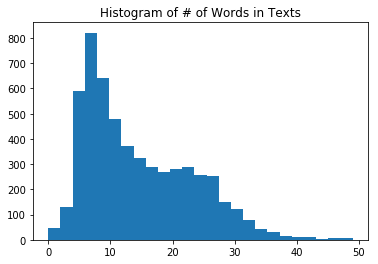

In [120]:
text_lengths = [len(x.split()) for x in texts]
text_lengths = [x for x in text_lengths if x < 50]
plt.hist(text_lengths, bins=25)
plt.title('Histogram of # of Words in Texts')
sentence_size = 50
min_word_freq = 3
plt.show()

## embedding: words from the vocabulary are mapped to vectors of real numbers

In [136]:
vocab_processor = learn.preprocessing.VocabularyProcessor(sentence_size, min_frequency=min_word_freq)
vocab_processor.fit_transform(texts)

embedding_size = len(vocab_processor.vocabulary_)

print(embedding_size )

2108


In [122]:
train_indices = np.random.choice(len(texts),round(len(texts)*0.8), replace=False)
test_indices = np.array(list(set(range(len(texts))) - set(train_indices)))

texts_train = [x for ix, x in enumerate(texts) if ix in train_indices]
texts_test = [x for ix, x in enumerate(texts) if ix in test_indices]

target_train = [x for ix, x in enumerate(target) if ix in train_indices]
target_test = [x for ix, x in enumerate(target) if ix in test_indices]

In [123]:
#
identity_mat = tf.diag(tf.ones(shape=[embedding_size]))  
#print(identity_mat)
#print(tf.ones(shape=[embedding_size]))

In [124]:
A = tf.Variable(tf.random_normal(shape=[embedding_size,1]))

b = tf.Variable(tf.random_normal(shape=[1,1]))
print(A.shape,b.shape)
# Initialize placeholders
x_data = tf.placeholder(shape=[sentence_size], dtype=tf.int32)
y_target = tf.placeholder(shape=[1, 1], dtype=tf.float32)

print(x_data.shape, len(y_data))

(2108, 1) (1, 1)
(50,) 1


In [125]:
#map the indices of the words in the sentence to the one-hot-encoded vectors of our identity matrix
x_embed = tf.nn.embedding_lookup(identity_mat, x_data)
#we create the sentence vector by summing up the aforementioned word vectors.
x_col_sums = tf.reduce_sum(x_embed, 0)

x_col_sums_2D = tf.expand_dims(x_col_sums, 0)

print(x_embed.shape, x_col_sums.shape,x_col_sums_2D.shape )

model_output = tf.add(tf.matmul(x_col_sums_2D, A), b)

(50, 2108) (2108,) (1, 2108)


In [126]:
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=y_target))
# Prediction operation
prediction = tf.sigmoid(model_output)
# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.001)
train_step = my_opt.minimize(loss)

In [127]:
init = tf.global_variables_initializer()
sess.run(init)

In [134]:
print("start training over %d sentences."%len(texts_train))

start training over 4459 sentences.


In [128]:
loss_vec = []
train_acc_all = []
train_acc_avg = []
for ix, t in enumerate(vocab_processor.fit_transform(texts_train)):
    #print(t)
    y_data = [[target_train[ix]]]
    sess.run(train_step, feed_dict={x_data: t, y_target: y_data})
    temp_loss = sess.run(loss, feed_dict={x_data: t, y_target: y_data})
    loss_vec.append(temp_loss)
    if (ix+1)%1000==0:
        print('Training Observation #' + str(ix+1) + ': Loss = ' +
    str(temp_loss))
# Keep trailing average of past 50 observations accuracy
# Get prediction of single observation
    [[temp_pred]] = sess.run(prediction, feed_dict={x_data:t, y_target:y_data})
# Get True/False if prediction is accurate
    train_acc_temp = target_train[ix]==np.round(temp_pred)
    train_acc_all.append(train_acc_temp)
    if len(train_acc_all) >= 50:
        train_acc_avg.append(np.mean(train_acc_all[-50:]))

Training Observation #1000: Loss = 0.0015600214
Training Observation #2000: Loss = 3.675388e-07
Training Observation #3000: Loss = 0.018842075
Training Observation #4000: Loss = 0.007851074


In [129]:
print('Getting Test Set Accuracy')
test_acc_all = []
for ix, t in enumerate(vocab_processor.fit_transform(texts_test)):
    y_data = [[target_test[ix]]]
    if (ix+1)%100==0:
        print('Test Observation #' + str(ix+1))
# Keep trailing average of past 50 observations accuracy
# Get prediction of single observation
    [[temp_pred]] = sess.run(prediction, feed_dict={x_data:t, y_target:y_data})
# Get True/False if prediction is accurate
    test_acc_temp = target_test[ix]==np.round(temp_pred)
    test_acc_all.append(test_acc_temp)
print('\nOverall Test Accuracy: {}'.format(np.mean(test_acc_all)))

Getting Test Set Accuracy
Test Observation #100
Test Observation #200
Test Observation #300
Test Observation #400
Test Observation #500
Test Observation #600
Test Observation #700
Test Observation #800
Test Observation #900
Test Observation #1000
Test Observation #1100

Overall Test Accuracy: 0.8026905829596412
